##Інсталювання необхідних бібліотек та підключення google drive

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import pylab
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import missingno as msno
from collections import Counter
from wordcloud import WordCloud
import pylab
import scipy.stats as stats
from scipy.stats import f_oneway

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Завантажуємо дані та робимо передобробку

In [173]:
df = pd.read_csv("/content/drive/MyDrive/async_all_labour_market_ua_22_07_2024_17_1.csv")

In [174]:
# подивимось загальний вигляд даних
df.head()

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Додаткова інформація,Посилання
0,"Системний адміністратор, інженер технічної під...",Coreberg IT Management,Київ,"IT, комп'ютери, інтернет",0,26000.0,40000.0,2.0,NaN,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/1953193/
1,Менеджер з продажу (ІТ),Poster,Київ,"IT, комп'ютери, інтернет",0,NaN,NaN,2.0,NaN,1,0,0,0,1,0,0,0,NaN,https://www.work.ua/jobs/5709818/
2,System Administrator,DiJust,Київ,"IT, комп'ютери, інтернет",0,NaN,NaN,5.0,NaN,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5734433/
3,Системний адміністратор,Джоб Хант,Київ,"IT, комп'ютери, інтернет",0,30000.0,60000.0,1.0,NaN,1,0,0,0,0,0,1,0,NaN,https://www.work.ua/jobs/5679871/
4,Проєктний менеджер напряму інтеграції партнерів,Дія,Київ,"IT, комп'ютери, інтернет",0,NaN,NaN,1.0,Вища освіта,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5745032/


In [175]:
# знайдемо загальну кількість записів
df.shape

(135927, 19)

In [176]:
# подивимось на дані більш детально
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135927 entries, 0 to 135926
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Назва роботи                     135927 non-null  object 
 1   Назва компанії                   135927 non-null  object 
 2   Місто                            135927 non-null  object 
 3   Категорія вакансії               135927 non-null  object 
 4   Стажування / Навчання на роботі  135927 non-null  int64  
 5   Мінімальна ЗП                    97415 non-null   float64
 6   Максимальна ЗП                   97415 non-null   float64
 7   Необхідний досвід                135927 non-null  float64
 8   Необхідна освіта                 41703 non-null   object 
 9   Повна зайнятість                 135927 non-null  int64  
 10  Неповна зайнятість               135927 non-null  int64  
 11  Студент                          135927 non-null  int64  
 12  Ін

<Axes: >

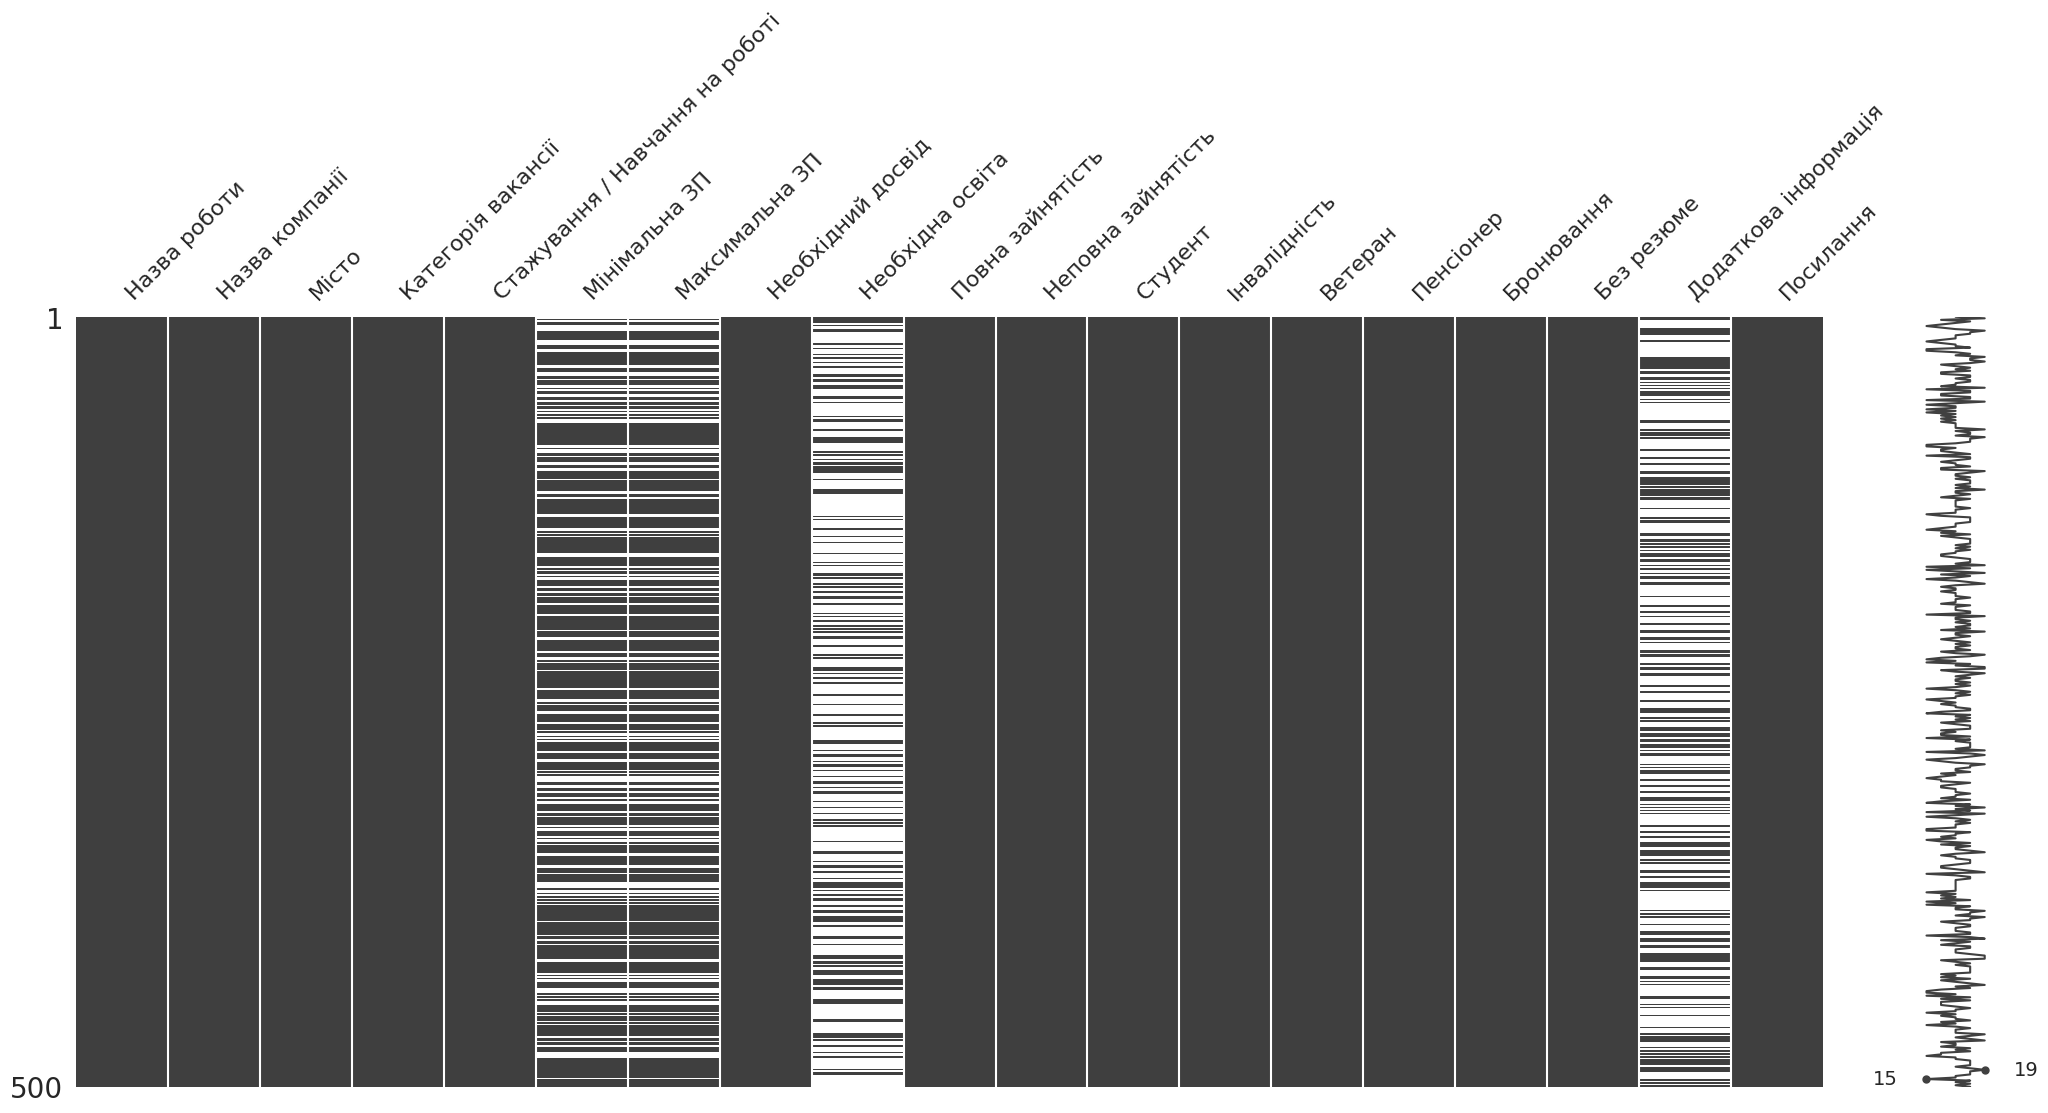

In [177]:
# зображемо графічно кількість пропущенних значаень у семплі розміром 500
msno.matrix(df.sample(500))

Як бачимо найбільше пропущено даних в стовпцях необхдіна освіта, додаткова інформація та мінімальна і максимальна ЗП, проте не поспішаємо видаляти перші дві колонки, з них можна витягнути купу цікаї інформації. А для колонок із зарплатою зробимо порівняльне дослідження

In [178]:
len(df["Місто"].unique())
# отримана кількість міст трохи більша аніж кількість адміністративних центрів
# в Україні, тож відберемо для подальшого аналізу тільки найбільші адмін. центри

380

In [179]:
# виділимо ці самі найбільші міста України
main_city = df.groupby("Місто").size().sort_values(ascending=False).head(23)
all_ukraine = df[df["Місто"] == "Вся Україна"]  # і окремо збережемо вакансії по всій Україні
cities = main_city.index.drop("Вся Україна")
df = df[df["Місто"].isin(cities)]

### Детально дослідим вакансії розміщені для всієй України

In [180]:
all_ukraine.shape

(5613, 19)

In [181]:
all_ukraine.head(2)

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Додаткова інформація,Посилання
14,Аналітик пункту управління розвідки,421 ОББпС,Вся Україна,"IT, комп'ютери, інтернет",0,22000.0,120000.0,0.0,NaN,1,0,1,1,1,1,0,0,NaN,https://www.work.ua/jobs/5702175/
19,"Майстер з налаштування БПЛА, військовослужбовець",225 ОШБ,Вся Україна,"IT, комп'ютери, інтернет",0,20000.0,120000.0,1.0,NaN,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5635481/


Загалом за особливостю структури сторінки сайту work.ua та роботи парсера в вакансіях, які розміщені для всієй України, пов'язані з військовою службою.

In [182]:
# Подивимось на топ10 слів в "Назві компанії"
Counter(" ".join(all_ukraine["Назва компанії"]).lower().split()).most_common(10)

[('частина', 1688),
 ('військова', 1662),
 ('батальйон', 1227),
 ('окремий', 1130),
 ('обр', 1128),
 ('тро', 1089),
 ('сил', 842),
 ('зсу', 749),
 ('омбр', 438),
 ('бригада', 392)]

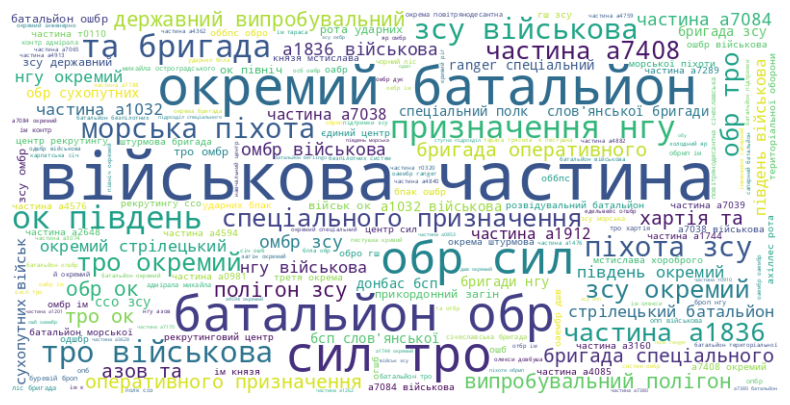

In [183]:
# тепер представимо це все у графічному вигляді
text = ' '.join(all_ukraine["Назва компанії"].dropna().str.lower())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [184]:
# швидка описова статистика військових вакансій
all_ukraine.describe()

,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме
count,5613.0,5439.000000,5439.000000,5613.000000,5613.0,5613.000000,5613.000000,5613.000000,5613.000000,5613.000000,5613.0,5613.000000
mean,0.0,26910.427101,95863.966354,0.690362,1.0,0.004276,0.109389,0.021735,0.090326,0.015856,0.0,0.414573
std,0.0,12316.983148,41582.446387,0.913377,0.0,0.065255,0.312154,0.145831,0.286674,0.124930,0.0,0.492692
min,0.0,19000.000000,19000.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,20000.000000,53000.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.0,21000.000000,120000.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.0,25000.000000,120300.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,0.0,120000.000000,190000.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [185]:
# також доробимо вимушені передобробки даних
df["Необхідний досвід"] = df["Необхідний досвід"].replace(6, 0.5)
df["Необхідний досвід"] = df["Необхідний досвід"].replace(3, 0.25)
df["Необхідна освіта"] = df["Необхідна освіта"].replace(np.NaN, "Не вказано")
# також видалимо всі вакансії пов'язані з військовими, щоб максимально побачити
# реальну ситуацію на цивільному ринку праці
df = df[~df["Назва компанії"].str
        .contains(r"ТрО|батальон|ЗСУ|батальйон|ОМБр|ОДШБр|Військова частина|РТЦК|української армії|ДШВ|ОБМП|ОБрМП|ОАеМБр|ОТЦК|ОЄБр|ОББпС|ОШБ|ОШБр|НГУ|ОАБр|ОГШБ|ОГШБр|ОБУ|ОМПБр|прикордонний загін|ОРБ|ОПП|окрема десантно-штурмова|окрема механізована|Дивізіон надводних кораблів|авіаційна комендатура|окрема бригада територіальної|окрема гірсько-штурмова|ОПБр|ОДШП|ОМІБр|ОПБ|Ranger|ВМС ЗС|25 Окрема повітрянодесантна|Війскова частина|підрозділ спеціального призначення|Окремий Спеціальний Центр Електронної Підтримки|Об'єднаний навчально-тренувальний центр|ОТБр|190 Навчальний Центр|ОСБ", na=False)]
# df = df[~(df["Назва компанії"] == "Компанія прихована")]  # залишимо компанії, назви яких приховано

##Проведемо певне дослідження по типу EDA

###Дослідження даних в яких не вказана заробітна плата

In [186]:
# всього наразі залишилося 125089 записів, що близько 8%
df.shape

(125089, 19)

In [187]:
# знайдемо відсоток пропущених даних заробітної плати, вони ідентичні у двох варіантах (через особливості парсеру)
print(df["Мінімальна ЗП"].isnull().sum() / df["Мінімальна ЗП"].count())

0.4237471403043513


Як бачимо ситуація доволі неприємна, бо ми маємо близько 42% пропущених даних стосовно заробітної плати і було б правильно видалити саме ці стовпчики (Мінімальна ЗП та Максимальна ЗП), проте загалом нас саме і цікавить інформація стосовно заробітних плат також ми маємо доволі велику виборку, тож для подальшого дослідження ми саме видалимо пусті значення в стовпчиках Мінімальна ЗП та Максимальна ЗП (через особливість збирача даних пусті значення, якщо вони є, знаходяться в однакових містах).

In [188]:
data = df[df["Мінімальна ЗП"].isna()]
data.shape  # всього пропущених даних по зарплатам - 37230

(37230, 19)

[Text(0, 0.5, 'Місто'), Text(0.5, 0, 'Кількість вакансій на Work.ua')]

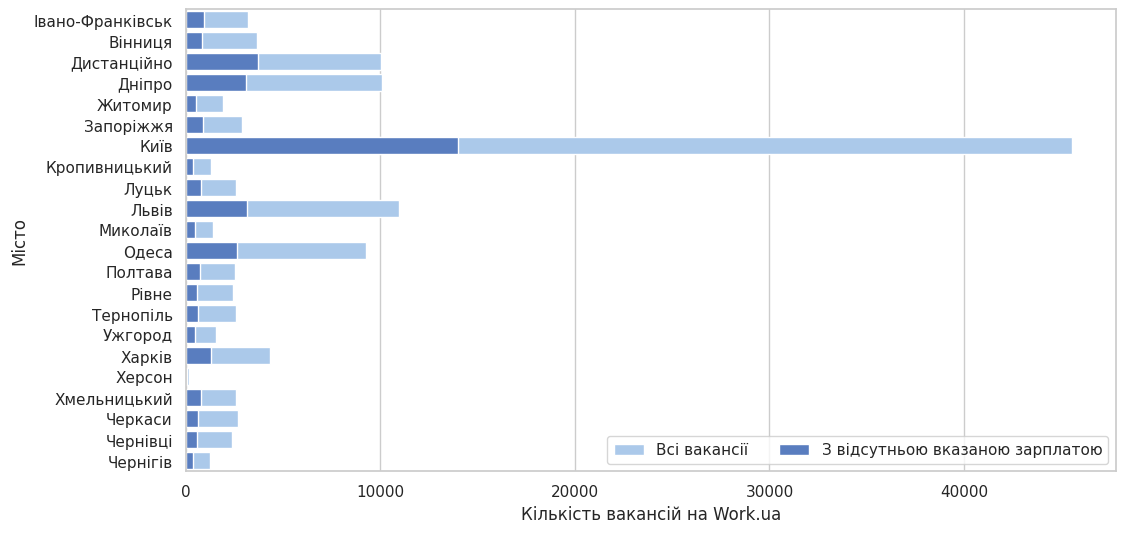

In [189]:
# зобразимо відношення кількісті вакансій з відсутніми даними по зарплаті до загальної кількості вакансій по містам України
grouped_data1 = df.groupby("Місто").size().reset_index(name="Кількість")
nan_category1 = data.groupby("Місто").size().reset_index(name="Кількість")

f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Кількість", y="Місто", data=grouped_data1,
            label="Всі вакансії", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Кількість", y="Місто", data=nan_category1,
            label="З відсутньою вказаною зарплатою", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Місто", xlabel="Кількість вакансій на Work.ua")
# sns.despine(left=True, bottom=True)

З графіку зрозуміло, що найбільше таких вакансій (з відсутньою вказаною заробітною платою) саме у великих розвинених містах України, що вцілому й не дивно. Цікаво спостерігати, що в топі також знаходяться вакансії з дистанційною зайнятістю.

[Text(0, 0.5, 'Категорії вакансій'),
 Text(0.5, 0, 'Кількість вакансій на Work.ua')]

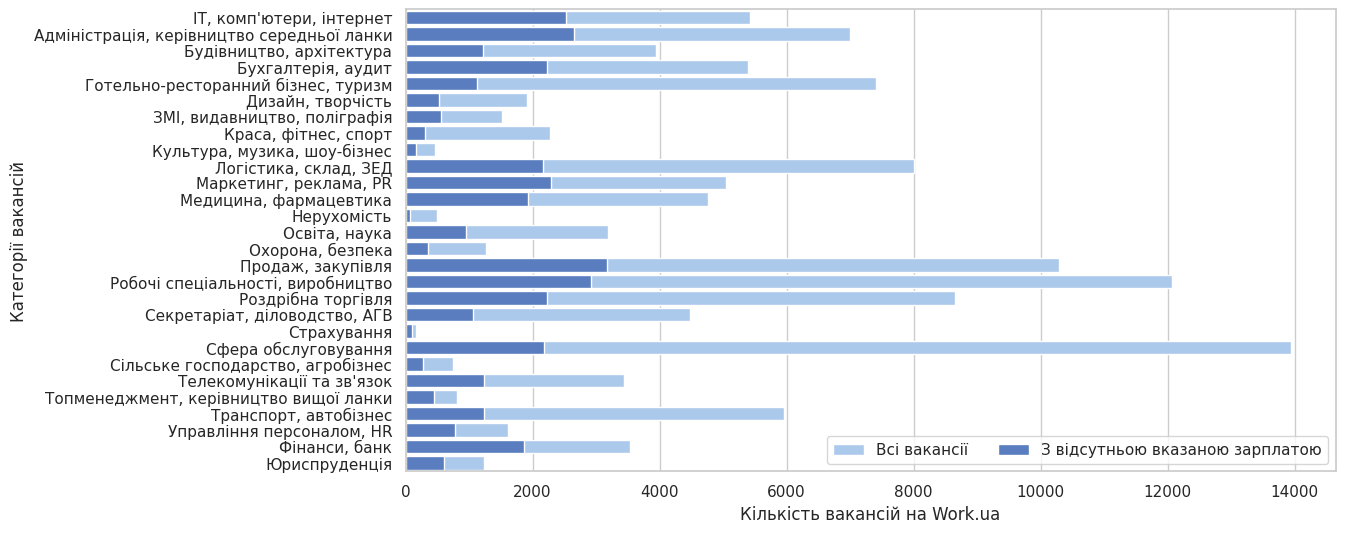

In [190]:
# зобразимо відношення кількісті вакансій з відсутніми даними по зарплаті до загальної кількості вакансій
grouped_data = df.groupby("Категорія вакансії").size().reset_index(name="Кількість")
nan_category = data.groupby("Категорія вакансії").size().reset_index(name="Кількість")

f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Кількість", y="Категорія вакансії", data=grouped_data,
            label="Всі вакансії", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Кількість", y="Категорія вакансії", data=nan_category,
            label="З відсутньою вказаною зарплатою", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Категорії вакансій", xlabel="Кількість вакансій на Work.ua")
# sns.despine(left=True, bottom=True)

In [191]:
# для більшої наочності зобразимо топ 5 категорій по найбільшому співвідношенню
merged_data = grouped_data.merge(nan_category, how="inner", on="Категорія вакансії")
merged_data.rename(columns={"Кількість_x": "Загальна кількість вакансій", "Кількість_y": "Кількість з відсутньою зарплатою"}, inplace=True)
merged_data["Співвідношення, %"] = merged_data["Кількість з відсутньою зарплатою"] / merged_data["Загальна кількість вакансій"]
# подивимося вакансії у яких найбільше співвідношення вакансій без явно вказаної зарплатні до загальної кількості вакансій по категоріям
merged_data.sort_values(by="Співвідношення, %", ascending=False).head(5)

,Категорія вакансії,Загальна кількість вакансій,Кількість з відсутньою зарплатою,"Співвідношення, %"
19,Страхування,173,101,0.583815
23,"Топменеджмент, керівництво вищої ланки",808,456,0.564356
26,"Фінанси, банк",3536,1865,0.527432
27,Юриспруденція,1242,610,0.491143
25,"Управління персоналом, HR",1614,785,0.486369


In [192]:
# подивимося вакансії у яких найменше співвідношення вакансій без явно вказаної зарплатні до загальної кількості вакансій по категоріям
merged_data.sort_values(by="Співвідношення, %", ascending=False).tail(5)

,Категорія вакансії,Загальна кількість вакансій,Кількість з відсутньою зарплатою,"Співвідношення, %"
24,"Транспорт, автобізнес",5959,1231,0.206578
20,Сфера обслуговування,13947,2178,0.156163
4,"Готельно-ресторанний бізнес, туризм",7402,1126,0.152121
7,"Краса, фітнес, спорт",2274,305,0.134125
12,Нерухомість,498,64,0.128514


In [193]:
# Подивимось на топ10 слів в "Назва роботи" на цивільному ринку праці
Counter(" ".join(df["Назва компанії"]).lower().split()).most_common(15)

[('тов', 16058),
 ('фоп', 9285),
 ('центр', 2260),
 ('флп', 2191),
 ('group', 2134),
 ('мережа', 2112),
 ('ооо', 1888),
 ('магазинів', 1623),
 ('компанія', 1399),
 ('пп', 1335),
 ('прат', 1081),
 ('ukraine', 1031),
 ('лінія', 1021),
 ('eva,', 1005),
 ('та', 889)]

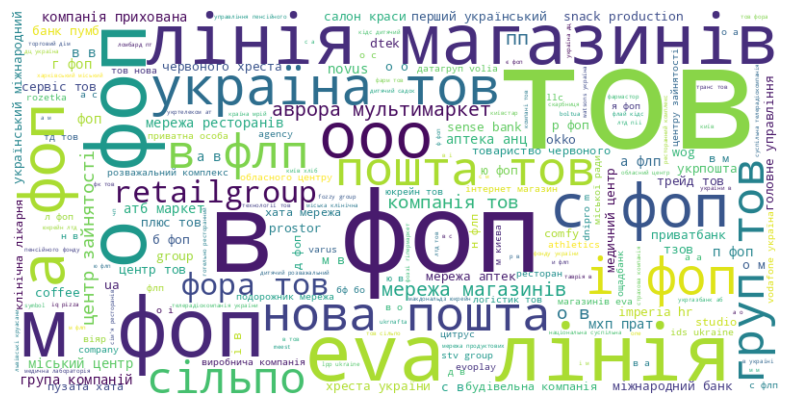

In [194]:
# для відносно кращого сприйняття представимо це все у графічному вигляді
text = ' '.join(df["Назва компанії"].dropna().str.lower())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Доволі складно інтерпретувати результати та проте видно, які слова властиві назвам вакансій в більшості випадках і якого типу вакансій більше. Ось наприклад бачимо назви компаній Сільпо, Аврора, Eva, Нова Пошта, які є лідерами зі сторони роботодавців, а також бачимо їх вид розподілу, тобто мережа (лінія) магазинів. Також бачимо значну кількість ФОП та ТОВ. Одже попри свою складність графік доволі інформативний.

In [195]:
df = df[df["Мінімальна ЗП"] >= 1700]
df = df.dropna(subset="Мінімальна ЗП")

Спробуємо перевірити певну гіпотезу щодо того, що вакансії без явно вказаної заробітної плати вимагають більше досвіду, на основі якого впродовж співбесіди і буде вирішено питання зарплати.

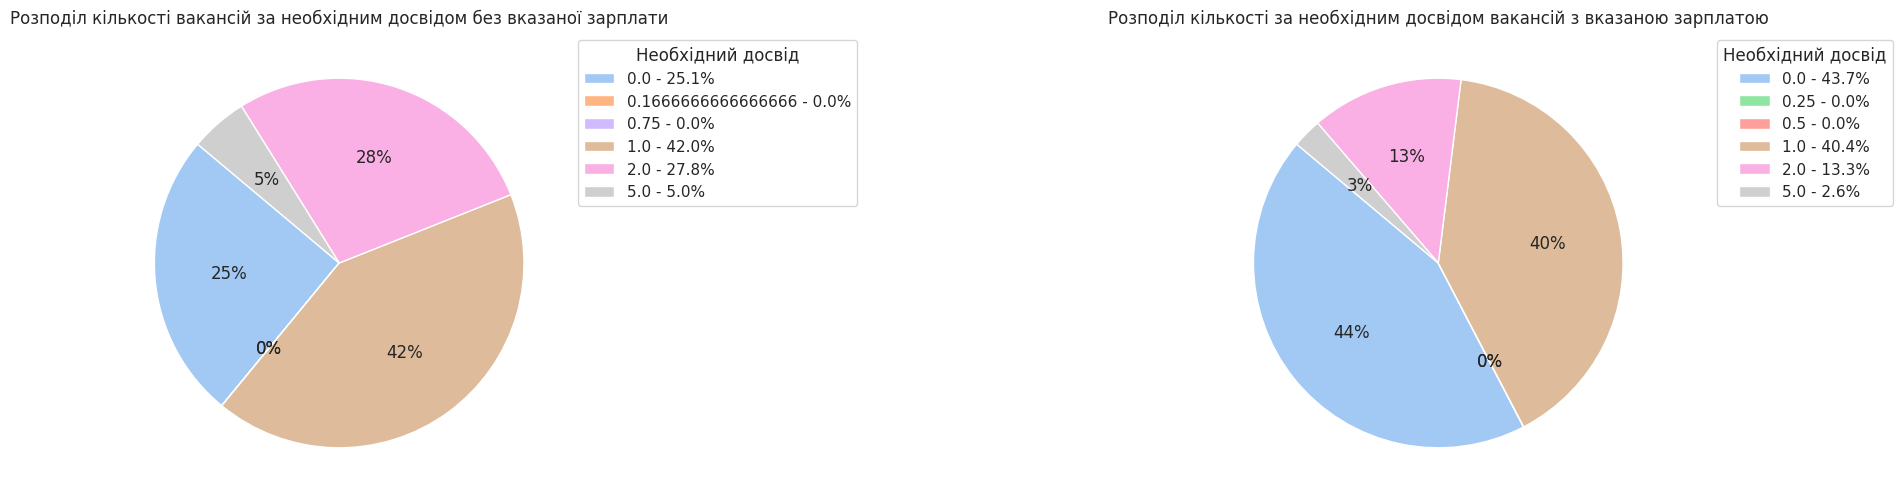

In [196]:
grouped_data3 = data.groupby("Необхідний досвід").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Необхідний досвід").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

all_experience_levels = sorted(set(grouped_data3.index).union(set(grouped_data4.index)))
colors = sns.color_palette("pastel", len(all_experience_levels))
color_mapping = {exp: color for exp, color in zip(all_experience_levels, colors)}

# Функція для отримання кольору відповідно до групи
def get_colors(grouped_data):
    return [color_mapping[exp] for exp in grouped_data.index]

f, ax = plt.subplots(1, 2, figsize=(26, 6))

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=get_colors(grouped_data3), autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Необхідний досвід", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій за необхідним досвідом без вказаної зарплати")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=get_colors(grouped_data4), autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Необхідний досвід", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості за необхідним досвідом вакансій з вказаною зарплатою")

plt.show()

Як бачимо наша гіпотеза має певне підтвердження, адже при невказаній зарплаті, більше вимагається досвіду за яким уже є сформовані навички кандидата, де вже під час співбесід(и) буде сформована його заробітна плата.

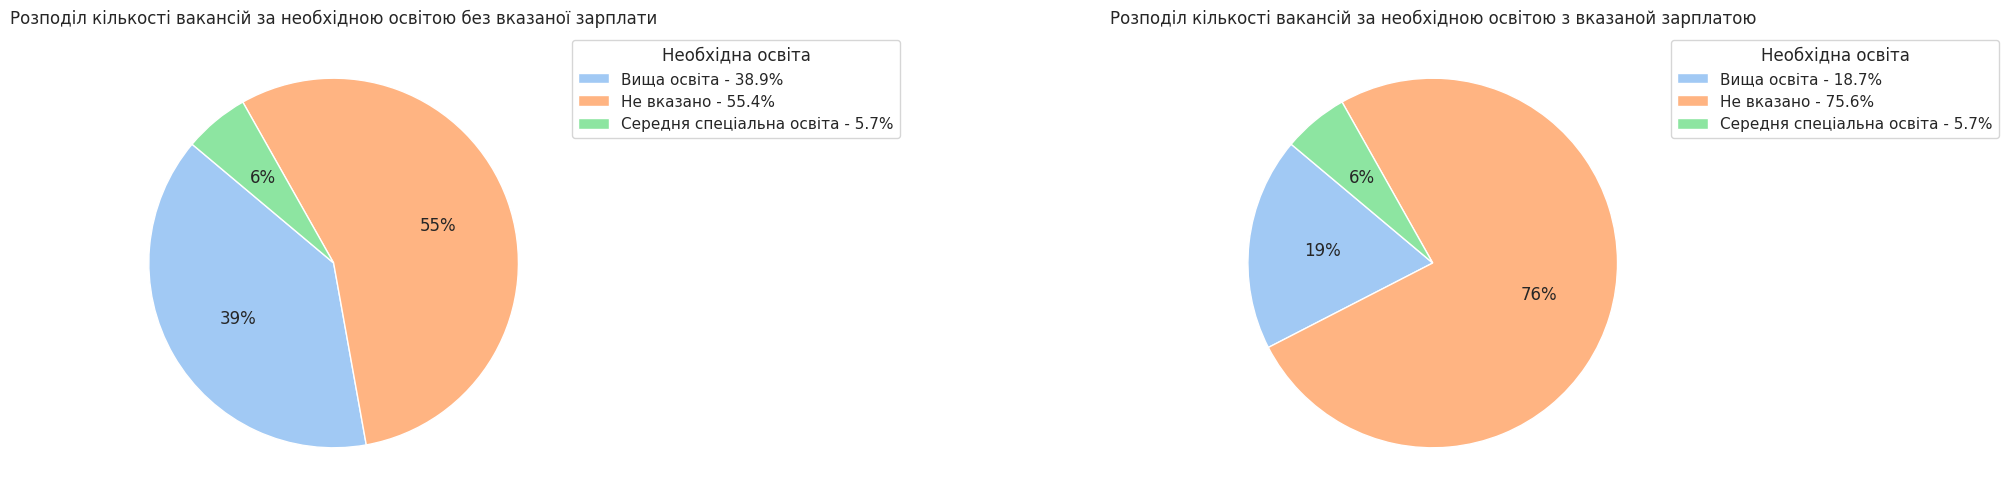

In [197]:
# також глянемо ситуацію щодо необхідної освіти
grouped_data3 = data.groupby("Необхідна освіта").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Необхідна освіта").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

f, ax = plt.subplots(1, 2, figsize=(26, 6))
colors = sns.color_palette("pastel")[0:6]

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Необхідна освіта", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій за необхідною освітою без вказаної зарплати")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Необхідна освіта", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості вакансій за необхідною освітою з вказаной зарплатою")

plt.show()

Тут теж ситуація доволі показова, ми бачимо наскільки, при явно невказаній зарплаті у вакансіях, збільшилася частка з вимогою вищої освіти, що теж підкріплює попередню нашу гіпотезу про спеціальні навички, за якими на етапах співбесід(и) формується заробітна плата.

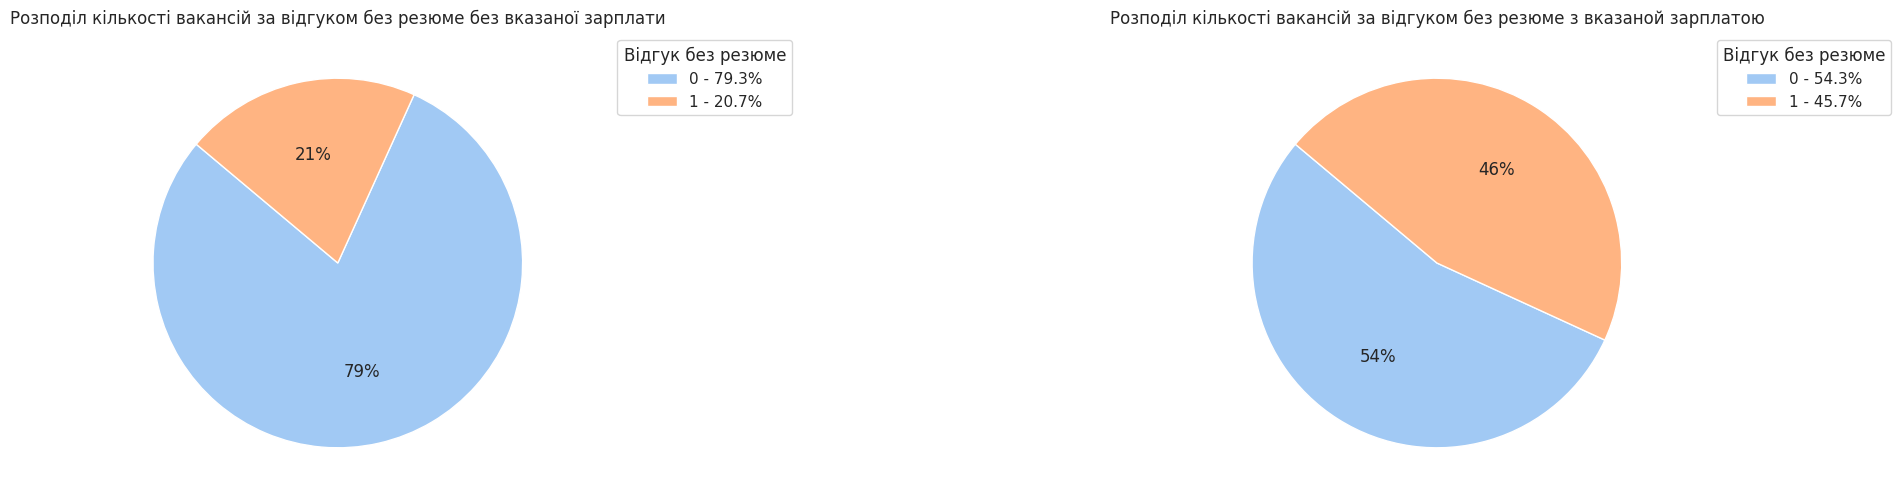

In [198]:
# на останок перевіримо ситуацію щодо можливості подавати відгук на вакансію без резюме
grouped_data3 = data.groupby("Без резюме").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Без резюме").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

f, ax = plt.subplots(1, 2, figsize=(26, 6))
colors = sns.color_palette("pastel")[0:6]

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Відгук без резюме", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій за відгуком без резюме без вказаної зарплати")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Відгук без резюме", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості вакансій за відгуком без резюме з вказаной зарплатою")

plt.show()

Цікаво спостерігати тут (відгук без резюме) зворотню ситуацію

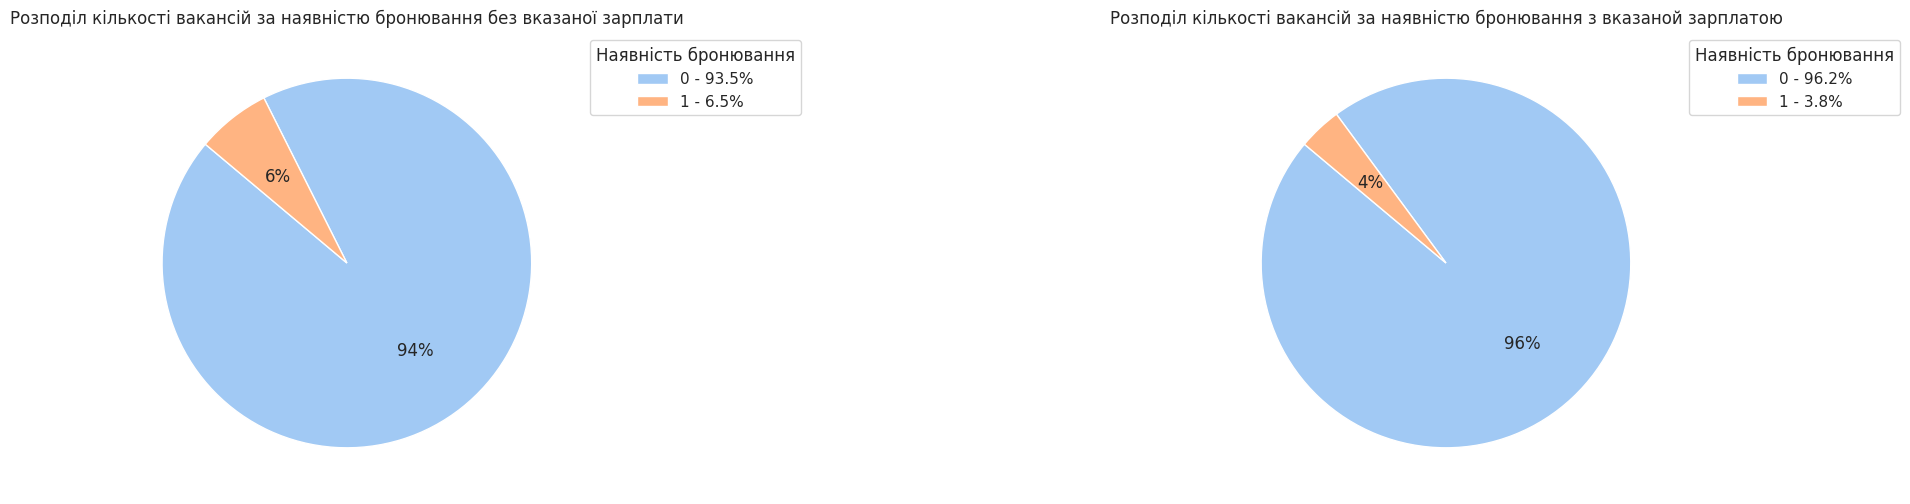

In [199]:
# на останок перевіримо ситуацію щодо можливості подавати відгук на вакансію без резюме
grouped_data3 = data.groupby("Бронювання").size()
percentages3 = grouped_data3 / grouped_data3.sum() * 100

grouped_data4 = df.groupby("Бронювання").size()
percentages4 = grouped_data4 / grouped_data4.sum() * 100

f, ax = plt.subplots(1, 2, figsize=(26, 6))
colors = sns.color_palette("pastel")[0:6]

# перший pie chart
wedges3, texts3, autotexts3 = ax[0].pie(grouped_data3, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels3 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data3.index, percentages3)]
ax[0].legend(wedges3, legend_labels3, title="Наявність бронювання", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[0].set_title("Розподіл кількості вакансій за наявністю бронювання без вказаної зарплати")

# другий pie chart
wedges4, texts4, autotexts4 = ax[1].pie(grouped_data4, colors=colors, autopct='%.0f%%', startangle=140)
legend_labels4 = [f'{label} - {percentage:.1f}%' for label, percentage in zip(grouped_data4.index, percentages4)]
ax[1].legend(wedges4, legend_labels4, title="Наявність бронювання", loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
ax[1].set_title("Розподіл кількості вакансій за наявністю бронювання з вказаной зарплатою")

plt.show()

Відносно нещодавно на сайті work.ua додали позначки на вакансії, які забезпечують бронювання, як бачимо таких вакансій доволі мало, проте для вакансій без явно вказаної ЗП таких вакансій більше

###Дослідження даних в яких вказана заробітна плата

Попри ньюанси, які виникли при відсіюванні даних зарплати зі значенням NaN, все ж спробуємо виконати першу поставлену ціль: дослідження ринку праці України та аналіз зарплат.

In [200]:
# цікаво буде глянути на мінімальну та максимальну заплати
print("Мінімальна зарплата по вакансіях:", df["Мінімальна ЗП"].min())
print("Максимальна зарплата по вакансіях:", df["Максимальна ЗП"].max())

Мінімальна зарплата по вакансіях: 1900.0
Максимальна зарплата по вакансіях: 400000.0


In [201]:
# далі порахуємо середню зарплату: для цього додамо стовпчик, де знайдемо
# середню заробітну плату між мінімально та максимально можливими зарплатами
# у вакансіях

df["Середня зарплата"] = (df["Мінімальна ЗП"] + df["Максимальна ЗП"]) / 2

In [202]:
df.head()

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Додаткова інформація,Посилання,Середня зарплата
0,"Системний адміністратор, інженер технічної під...",Coreberg IT Management,Київ,"IT, комп'ютери, інтернет",0,26000.0,40000.0,2.0,Не вказано,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/1953193/,33000.0
3,Системний адміністратор,Джоб Хант,Київ,"IT, комп'ютери, інтернет",0,30000.0,60000.0,1.0,Не вказано,1,0,0,0,0,0,1,0,NaN,https://www.work.ua/jobs/5679871/,45000.0
7,Digital інтернет-маркетолог,Slon Credit,Київ,"IT, комп'ютери, інтернет",0,24000.0,25000.0,0.0,Не вказано,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5744419/,24500.0
10,"Молодший аналітик, Junior data analyst","Онлайн Фінанс, ФК, ТОВ",Київ,"IT, комп'ютери, інтернет",0,18000.0,22000.0,0.0,Не вказано,1,0,0,0,0,0,0,0,ТОВ,https://www.work.ua/jobs/5601304/,20000.0
11,Майстер з ремонту мобільних телефонів,"Мастерфон, сеть сервис-центров",Київ,"IT, комп'ютери, інтернет",0,35000.0,45000.0,1.0,Вища освіта,1,0,0,1,1,0,0,1,сеть сервис-центров,https://www.work.ua/jobs/25055/,40000.0


In [204]:
# зробимо коротку описову статистику
df.describe()

,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Середня зарплата
count,87827.000000,87827.000000,87827.000000,87827.000000,87827.0,87827.000000,87827.000000,87827.000000,87827.000000,87827.000000,87827.000000,87827.000000,87827.000000
mean,0.012946,20934.730664,28349.764833,0.797873,1.0,0.136997,0.306580,0.136302,0.120327,0.072734,0.037893,0.457365,24642.247748
std,0.113042,11595.773722,18429.540295,0.969298,0.0,0.343846,0.461076,0.343111,0.325346,0.259701,0.190938,0.498182,14377.562370
min,0.000000,1900.000000,2000.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,0.000000,15000.000000,18000.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16500.000000
50%,0.000000,19000.000000,25000.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21420.000000
75%,0.000000,25000.000000,32000.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,28500.000000
max,1.000000,300000.000000,400000.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,310000.000000


In [205]:
# подивимося вакансії з мінімальною заробітною платою за місяць
df[df["Мінімальна ЗП"] == df["Мінімальна ЗП"].min()]

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Додаткова інформація,Посилання,Середня зарплата
50844,"Фотограф (Instagram, предметна фотозйомка)","Yorokobi, аниме-магазин",Одеса,"Дизайн, творчість",0,1900.0,2500.0,1.0,Не вказано,1,1,1,0,0,0,0,0,аниме-магазин,https://www.work.ua/jobs/5749931/,2200.0
50945,"Фотограф (Instagram, предметна фотозйомка)","Yorokobi, аниме-магазин",Одеса,"ЗМІ, видавництво, поліграфія",0,1900.0,2500.0,1.0,Не вказано,1,1,1,0,0,0,0,0,аниме-магазин,https://www.work.ua/jobs/5749931/,2200.0
51190,"Фотограф (Instagram, предметна фотозйомка)","Yorokobi, аниме-магазин",Одеса,"Культура, музика, шоу-бізнес",0,1900.0,2500.0,1.0,Не вказано,1,1,1,0,0,0,0,0,аниме-магазин,https://www.work.ua/jobs/5749931/,2200.0


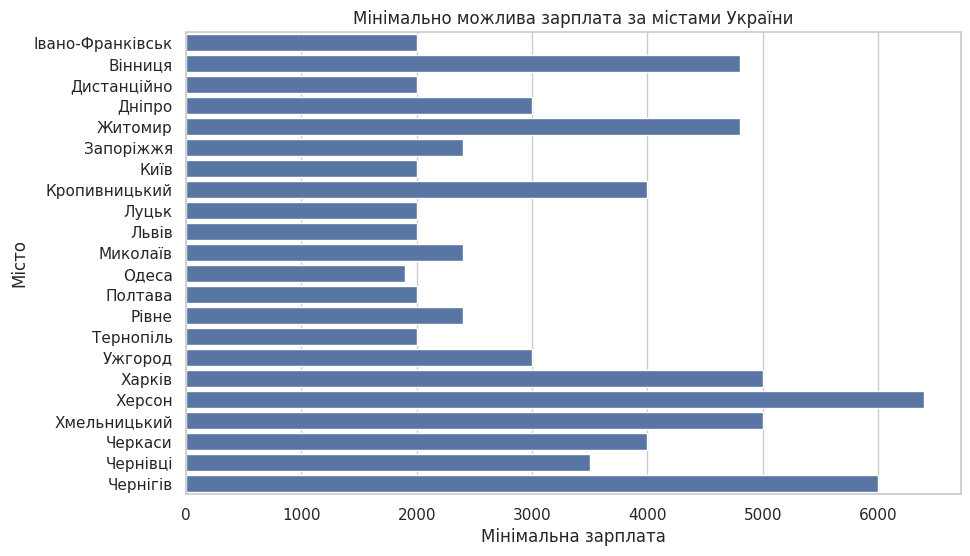

In [206]:
# потім глянемо на мінімальні зарплати по містам України
grouped_data_5 = df.groupby("Місто")["Мінімальна ЗП"].min().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_5, y="Місто", x="Мінімальна ЗП")
plt.title("Мінімально можлива зарплата за містами України")
plt.ylabel("Місто")
plt.xlabel("Мінімальна зарплата")

plt.show()

In [207]:
# також переглянемо вакансії з найбільшою зарплатою
df[df["Максимальна ЗП"] == df["Максимальна ЗП"].max()]

,Назва роботи,Назва компанії,Місто,Категорія вакансії,Стажування / Навчання на роботі,Мінімальна ЗП,Максимальна ЗП,Необхідний досвід,Необхідна освіта,Повна зайнятість,Неповна зайнятість,Студент,Інвалідність,Ветеран,Пенсіонер,Бронювання,Без резюме,Додаткова інформація,Посилання,Середня зарплата
126481,"Team Lead (Facebook, Gambling)",044 аgency.,Дистанційно,"IT, комп'ютери, інтернет",0,200000.0,400000.0,1.0,Не вказано,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5435512/,300000.0
130458,"Team Lead (Facebook, Gambling)",044 аgency.,Дистанційно,"Маркетинг, реклама, PR",0,200000.0,400000.0,1.0,Не вказано,1,0,0,0,0,0,0,0,NaN,https://www.work.ua/jobs/5435512/,300000.0


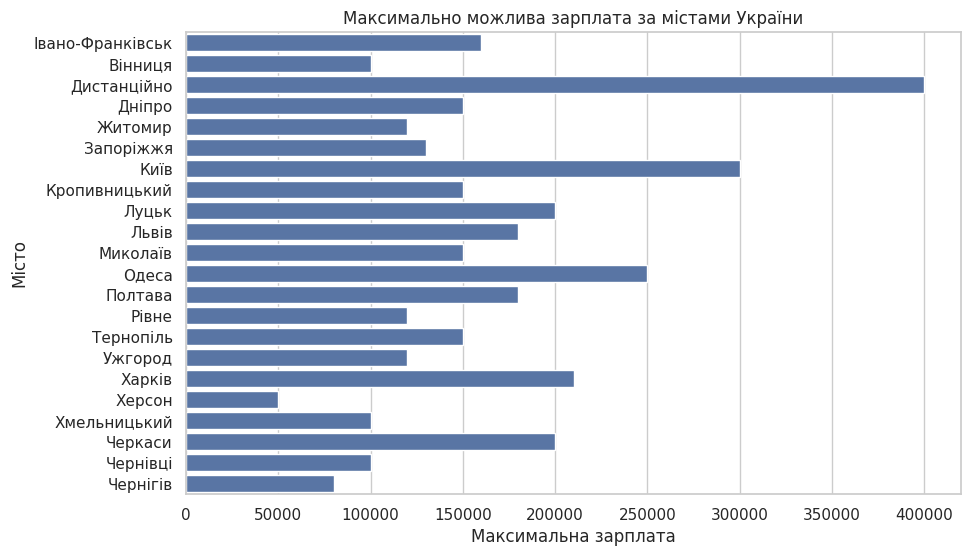

In [208]:
# переглянемо максимально можливі зарплати по містам України
grouped_data_6 = df.groupby("Місто")["Максимальна ЗП"].max().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_6, y="Місто", x="Максимальна ЗП")
plt.title("Максимально можлива зарплата за містами України")
plt.ylabel("Місто")
plt.xlabel("Максимальна зарплата")

plt.show()

In [210]:
# близько 13,69% вакансій пропонують неповну/часткову зайнятість
df["Неповна зайнятість"].sum() / df.shape[0]

0.13699659557994695

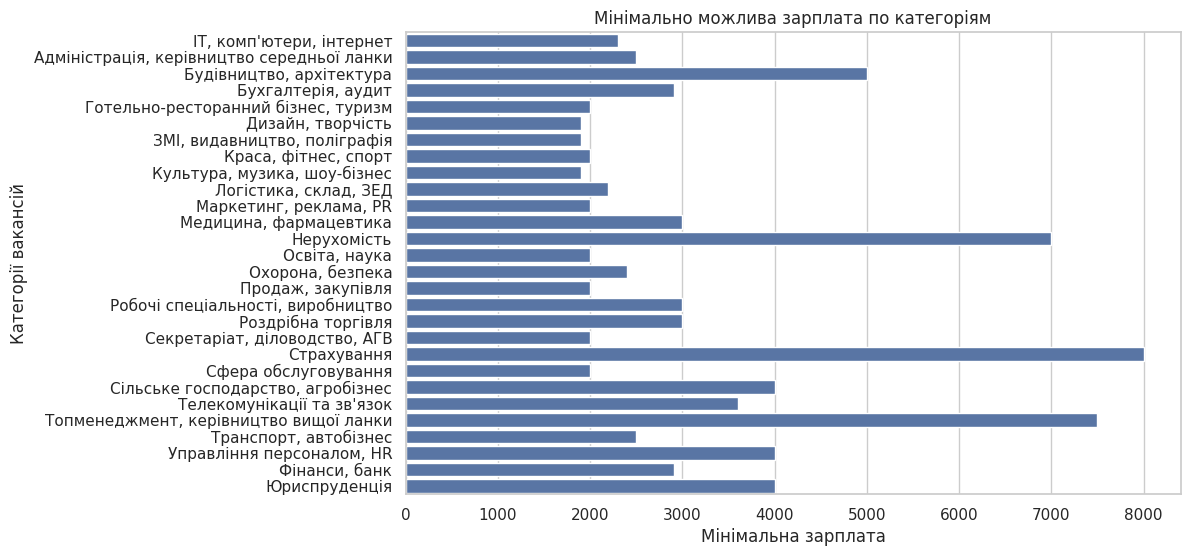

In [211]:
# мінімально можлива зарплата по категоріям, які доступні на work.ua
grouped_data_7 = df.groupby("Категорія вакансії")["Мінімальна ЗП"].min().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_7, y="Категорія вакансії", x="Мінімальна ЗП")
plt.title("Мінімально можлива зарплата по категоріям")
plt.ylabel("Категорії вакансій")
plt.xlabel("Мінімальна зарплата")

plt.show()

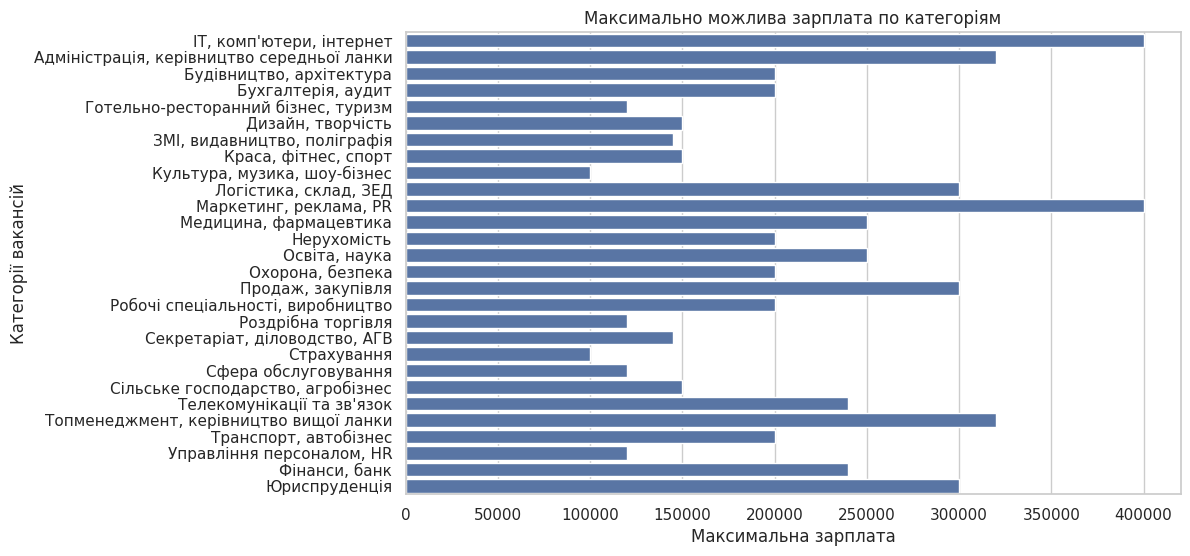

In [212]:
# максимально можлива зарплата по категоріям, які доступні на work.ua
grouped_data_8 = df.groupby("Категорія вакансії")["Максимальна ЗП"].max().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data_8, y="Категорія вакансії", x="Максимальна ЗП")
plt.title("Максимально можлива зарплата по категоріям")
plt.ylabel("Категорії вакансій")
plt.xlabel("Максимальна зарплата")

plt.show()

In [213]:
# також переглянемо найбільших роботодавців на ринку (топ-15)
# та їх частку від загального ринку праці України
temp_t = df.groupby("Назва компанії").size().sort_values(ascending=False).head(10)
comp_df = pd.DataFrame(temp_t).reset_index()
comp_df.columns = ["Назва компанії", "Кількість вакансій компанії"]
comp_df["Частка від загальної кількості вакансій"] = comp_df["Кількість вакансій компанії"] / df.shape[0]
comp_df.head(15)

,Назва компанії,Кількість вакансій компанії,Частка від загальної кількості вакансій
0,Novus,695,0.007913
1,RetailGroup,648,0.007378
2,Сільпо,546,0.006217
3,"Нова пошта, ТОВ",524,0.005966
4,WOG,482,0.005488
5,"Аврора, мультимаркет",470,0.005351
6,"Фора, ТОВ",421,0.004794
7,Аптека АНЦ,316,0.003598
8,ПриватБанк,306,0.003484
9,OKKO,274,0.003120


In [214]:
# Виключно з моєї цікавості хочу переглянути скільки в середньому отримують вчителя англійської мови
pattern = r"(вчитель|викладач|репетитор).*англійськ|англійськ.*(вчитель|викладач|репетитор)"
eng_data = df[df["Назва роботи"].str.contains(pattern, case=False, na=False)]
print("Всього було знайдено:", eng_data.shape[0], "з викладання англійської мови")
print("Середня зарплата з викладання англійської:", eng_data["Середня зарплата"].mean().round(2))
print("Максимально можлива зарплата з викладання англійської:", eng_data["Максимальна ЗП"].max().round(2))
print("Мінімально можлива зарплата з викладання англійської:", eng_data["Мінімальна ЗП"].min().round(2))
print("Необхідний середній досвід за вакансіями:", eng_data["Необхідний досвід"].mean().round(2))

Всього було знайдено: 426 з викладання англійської мови
Середня зарплата з викладання англійської: 21825.47
Максимально можлива зарплата з викладання англійської: 70000.0
Мінімально можлива зарплата з викладання англійської: 2000.0
Необхідний середній досвід за вакансіями: 0.81


<ipython-input-214-2bb5c920343b>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  eng_data = df[df["Назва роботи"].str.contains(pattern, case=False, na=False)]


<ipython-input-215-609cc538640d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Середня зарплата", y="Місто", palette="vlag")


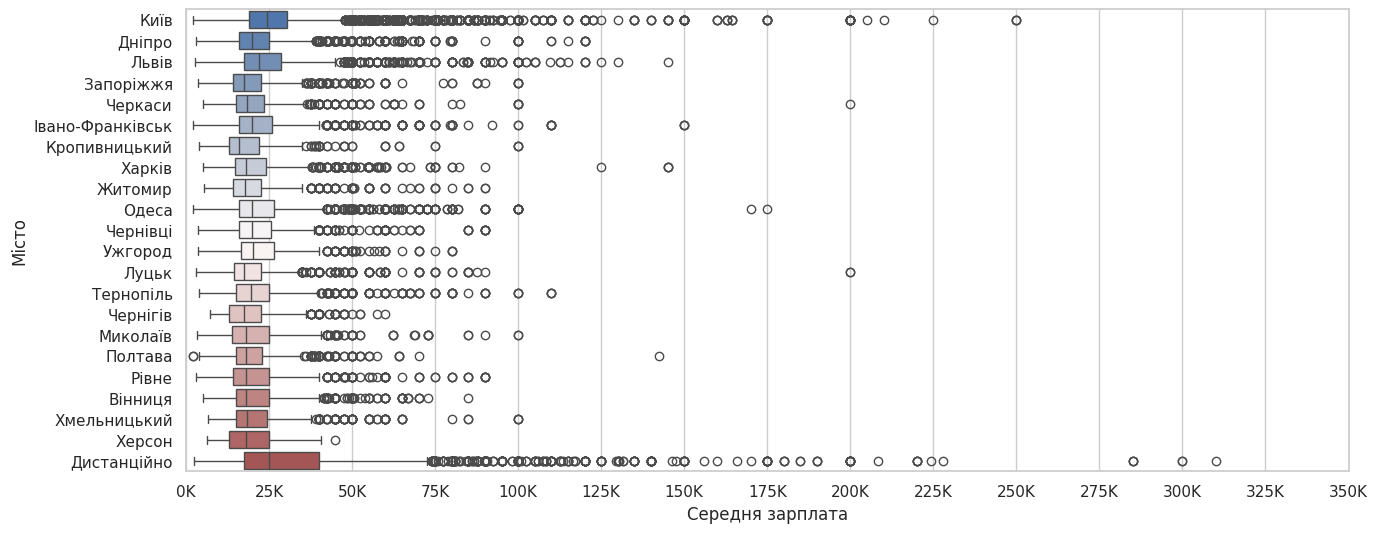

In [215]:
# побудуємо боксплоти середньої зарплати по містам України
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x="Середня зарплата", y="Місто", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlim = (0, 350000))
xticks = np.arange(0, 350001, 25000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{int(tick/1000)}K' for tick in xticks])

plt.show()

Спостерігаємо наступне, що медіана середньої зарплати (трішки дивно звучить та все ж) перетинає в позначці зарплати 25000 грн. тільки в дистанційному форматі, що вцілому й не дивно, та проте всі інші міста не доходять до цього показника, що не є позитивним знаком.

<ipython-input-218-7199a55e01ec>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Середня зарплата", y="Категорія вакансії", palette="vlag")


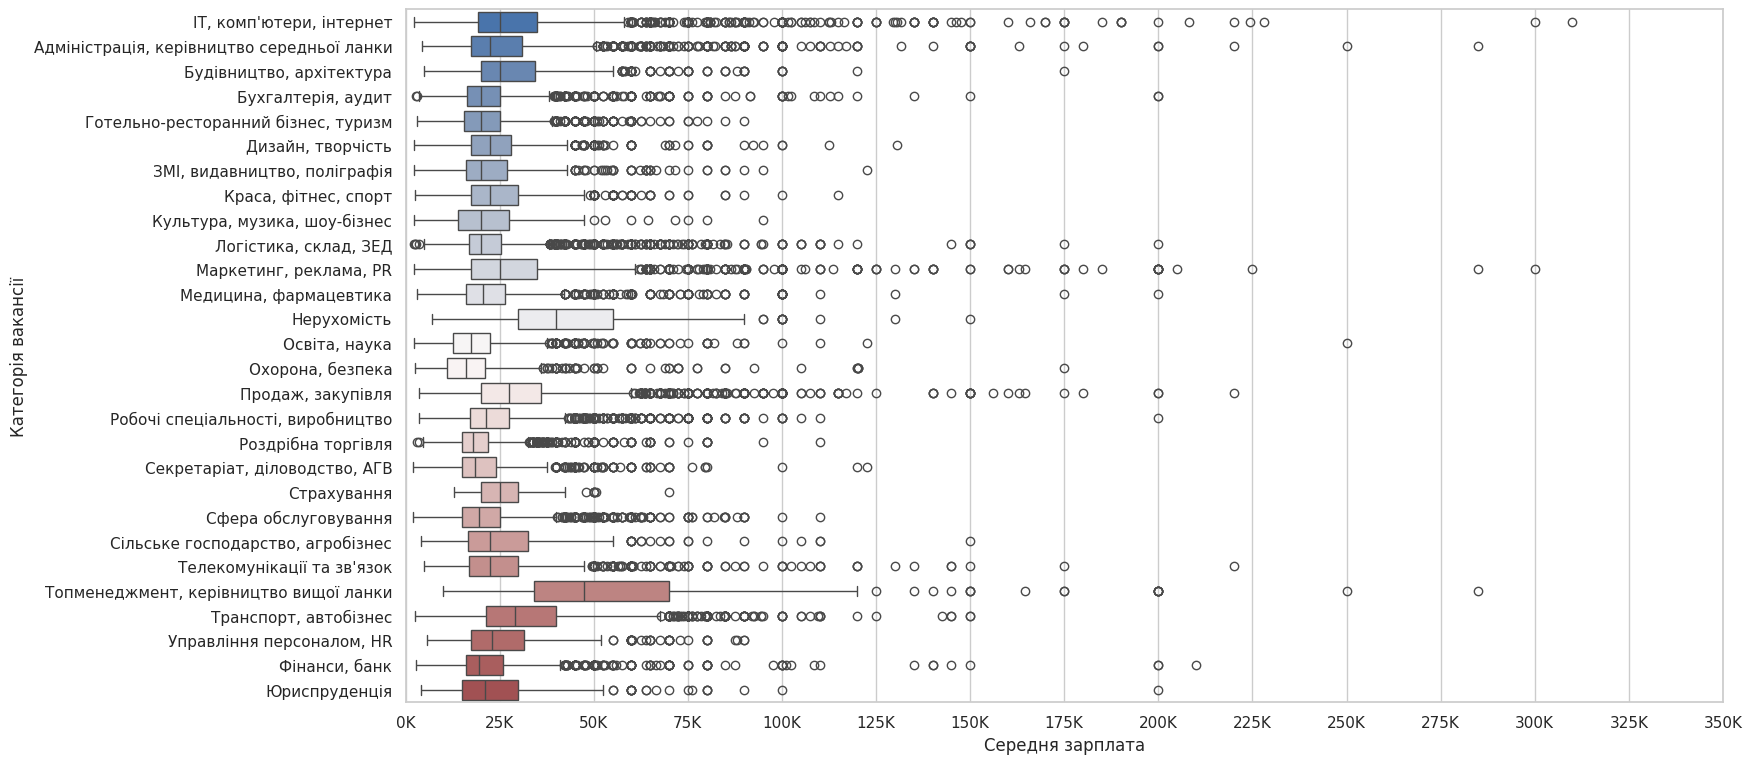

In [218]:
# і також для більшої наочності побудуємо боксплоти середньої зарплати по
# категоріям при цьому обмежевши категорії: адмiнiстрацiя,
# керівництво середньої ланки; Маркетинг, реклама, PR з максимальними зарплатами
f, ax = plt.subplots(figsize=(17, 9))
sns.boxplot(data=df, x="Середня зарплата", y="Категорія вакансії", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlim = (0, 350000))
xticks = np.arange(0, 350001, 25000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{int(tick/1000)}K' for tick in xticks])

plt.show()

З цього графіку видно, що найменша медіана середньої зарплати по категоріям є саме у робітників "охорони та безпеки". В свою чергу в топі знаходяться категорії пов'язані з нерухомістю та топменеджментом, що доволі очевидно.

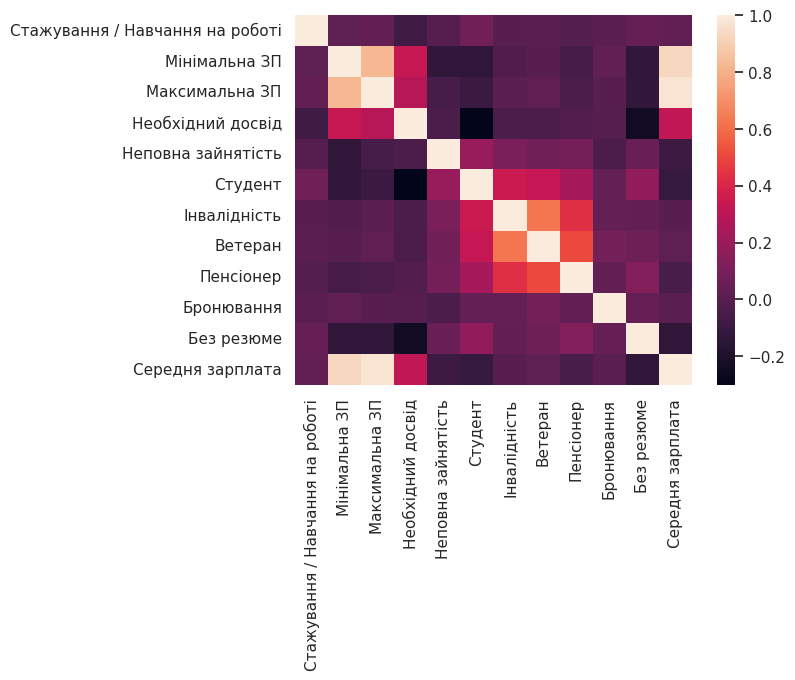

In [229]:
# також перевіремо кореляцію
test_data = df[["Стажування / Навчання на роботі", "Мінімальна ЗП", "Максимальна ЗП", "Необхідний досвід", "Неповна зайнятість", "Студент", "Інвалідність", "Ветеран", "Пенсіонер", "Бронювання", "Без резюме", "Середня зарплата"]]
corr = test_data.corr()

sns.heatmap(corr)
plt.show()

Як такої кореляції до середньої зарплати немає (мінімальна та максмиальна ЗП мають найвищу кореляцію, це й не дивно адже вони лежать в основі середньої ЗП)

##Статистичні тести

Перш за все проведемо односторонній тест ANOVA (при alpha=0,5), щоб зрозуміти чи відрізняються середні значення середніх зарплат по категоріям

In [242]:
group_main = df[["Категорія вакансії", "Середня зарплата"]].groupby("Категорія вакансії")
groups = [group_main.get_group(i)["Середня зарплата"].values for i in df["Категорія вакансії"].unique()]
f_val, p_val = stats.f_oneway(*groups)
print( "результати ANOVA: F=", f_val, ", P =", p_val )

результати ANOVA: F= 409.6386299119272 , P = 0.0


як бачимо що p_val < alpha, тобто ми повинні відхилити нульову гіпотезу про рівність груп, на користь альтернативної про відмінність середньої зарплати між групами.

Далі мені доволі цікаво буде глянути чи статистично значущо відрізняються середні зарплати в категоряіх "Освіта, наука" та "ІТ" на ринку праці в Україні. Тож висуваємо гіпотезу H0 - що змін в зарплаті ніяких немає та H1 - що відмінність всеж є.

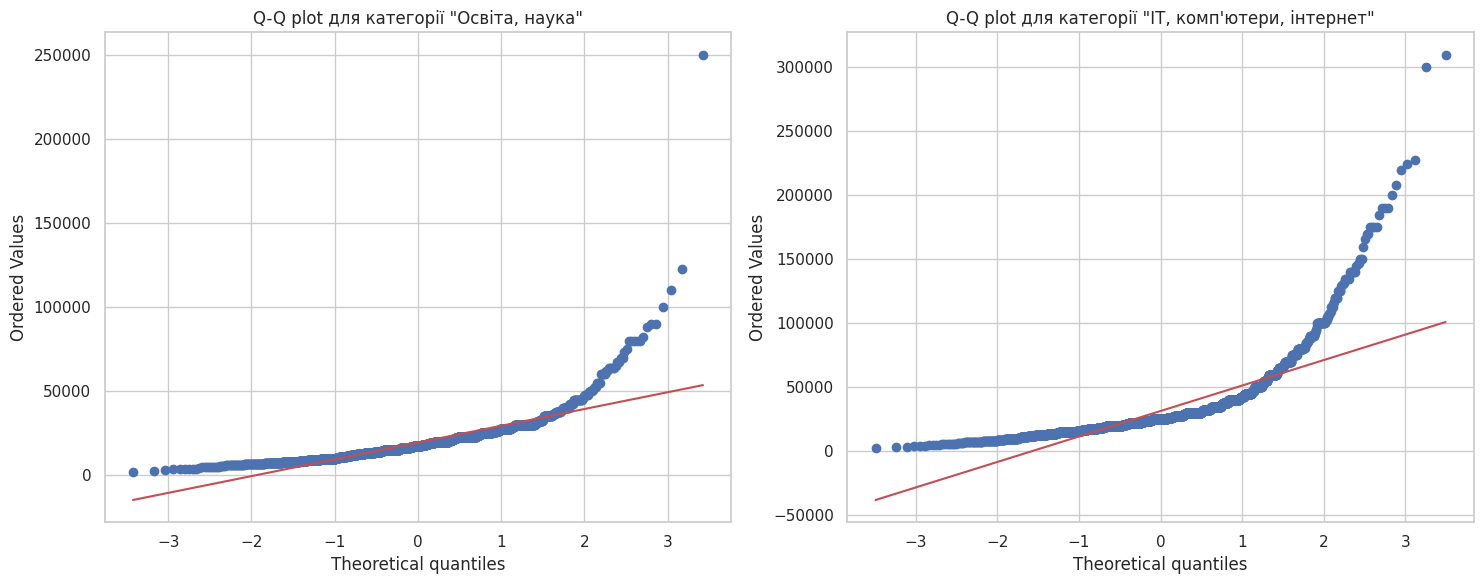

In [244]:
# спочатку перевіримо нормальність розподілу наших вибірок візуально через QQ-plot
f, ax = plt.subplots(1, 2, figsize=(15, 6))
group1 = df[df["Категорія вакансії"] == "Освіта, наука"]["Середня зарплата"]
stats.probplot(group1, dist="norm", plot=ax[0])
ax[0].set_title('Q-Q plot для категорії "Освіта, наука"')

group2 = df[df["Категорія вакансії"] == "IT, комп'ютери, інтернет"]["Середня зарплата"]
stats.probplot(group2, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q plot для категорії "IT, комп\'ютери, інтернет"')

plt.tight_layout()
plt.show()

Ситуація доволі показова, в обох випадках маємо розподіл, який відрізняється від нормального, тож в даному випадку будемо використовувати непараметричний аналог t-test, а саме критерій Манна-Уітні

In [245]:
# реалізуємо критерій Манна-Уітні
stat, p_value = mannwhitneyu(group1, group2)
print("Критерій Манна_уітні: p-value =", p_value)
if p_value > 0.01:
  print("Відхиляємо альтернативну гіпотезу (Н1) на користь Н0, тобто середні зарплати не відрізняються")
else:
  print("Відхиляємо нульову гіпотезу (Н0) на користь Н1, тобто середні зарплати відрізняються")

Критерій Манна_уітні: p-value = 2.5128274847249522e-167
Відхиляємо нульову гіпотезу (Н0) на користь Н1, тобто середні зарплати відрізняються


In [ ]:
# зберігаємо датасет
df.to_csv("/content/drive/MyDrive/data for training/all_labour_market_ua_2024-05-23_edited1.csv")